In [1]:
import os, random

import numpy as np
import tensorflow as tf

from sys import path
from PIL import Image
from scipy.ndimage import imread
from scipy.misc import imresize
from scipy.stats import pearsonr
from sklearn.metrics import roc_curve, auc

code_dir = os.path.join(os.path.abspath("."), "Functions")
path.append(code_dir)
data_dir = './PreProcessed/'

import InterfacePreprocessing as IntPre
import importFunctions as iF

In [2]:
global raw_only, image_size, num_layer
raw_only = True
raw_image_size = 150
image_size= 88

if raw_only:
    num_layer = 1
else:
    num_layer = 6

p_matching = 0.5
num_filter_1 = 20
num_filter_2 = 40
num_filter_3 = 60

In [3]:
def weight_variable(shape, name_str):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name = name_str)

def bias_variable(shape, name_str):
    initial = tf.constant(0.3, shape=shape)
    return tf.Variable(initial, name = name_str)

def conv2d(x, W, stride=[1, 1, 1, 1]):
    return tf.nn.conv2d(x, W, strides=stride, padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [12]:
# Smaller Dataset for testing/validation
images_match_small, images_mismatch_small = iF.load_pairs_from_preprocessed("../Fingerprint_Data/PreProcessed/Match/", 
                                                                "../Fingerprint_Data/PreProcessed/MisMatch/", 
                                                                image_size, num_layer, True)

# Full Dataset
images_match, images_mismatch = iF.load_pairs_from_preprocessed("../Fingerprint_Data/Processed_Full_CASIA/Match/", 
                                                                "../Fingerprint_Data/Processed_Full_CASIA/MisMatch/", 
                                                                image_size, num_layer, False)

# images_match, images_mismatch = iF.load_pairs_from_preprocessed("../Fingerprint_Data/PreProcessed/Match/", 
#                                                                 "../Fingerprint_Data/PreProcessed/MisMatch/", 
#                                                                 image_size, num_layer, True)

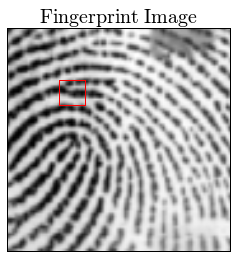

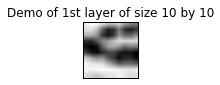

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline

if num_layer == 1:
    key = images_match.keys()[16]
    filter1_size = 10
    
    fig,ax = plt.subplots(1)
    ax.imshow(images_match[key][:,:,0],cmap = 'gray')
    ax.set_title(r'$\mathrm{Fingerprint \ Image}$', fontsize = 20)
    ax.set_xticks([]), ax.set_yticks([])
    rect = patches.Rectangle((20,20),filter1_size,filter1_size,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    

    plt.figure(figsize=(1,1))
    plt.title('Demo of 1st layer of size %d by %d' %(filter1_size, filter1_size))
    plt.imshow(images_match[key][20:20+filter1_size,20:20+filter1_size,0],cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    
else:
    key = images_match.keys()[16]
    fig = plt.figure(figsize=(12, 7))

    plt.subplot(2,3,1)
    plt.imshow(images_match[key][:,:,0],cmap = 'gray')  
    plt.title(r'$\mathrm{Fingerprint \ Image}$', fontsize = 20)
    plt.xticks([]), plt.yticks([])

    plt.subplot(2,3,2)
    plt.imshow(images_match[key][:,:,2],cmap = 'jet')  
    plt.title(r'$\mathrm{Orientation \ Map}$', fontsize = 20)
    plt.xticks([]), plt.yticks([])

    plt.subplot(2,3,3)
    plt.imshow(images_match[key][:,:,3],cmap = 'jet')  
    plt.title(r'$\mathrm{Abs \ Orientation \ Map}$', fontsize = 20)
    plt.xticks([]), plt.yticks([])

    plt.subplot(2,3,4)
    plt.imshow(images_match[key][:,:,1],cmap = 'jet')  
    plt.title(r'$\mathrm{Frequency \ Map}$', fontsize = 20)
    plt.xticks([]), plt.yticks([])

    plt.subplot(2,3,5)
    plt.imshow(images_match[key][:,:,4],cmap = 'jet')  
    plt.title(r'$\mathrm{Variance \ Map}$', fontsize = 20)
    plt.xticks([]), plt.yticks([])

    plt.subplot(2,3,6)
    plt.imshow(images_match[key][:,:,5],cmap = 'gray')  
    plt.title(r'$\mathrm{Gabor \ Filter}$', fontsize = 20)
    plt.xticks([]), plt.yticks([]);

In [14]:
# These two are input images
x = tf.placeholder(tf.float32, shape=[None, image_size*image_size*num_layer])
x_p = tf.placeholder(tf.float32, shape=[None, image_size*image_size*num_layer])

# y_ is just a value 0(match) or 1(no match) for the two input images
y_ = tf.placeholder(tf.float32, shape=[None, 1])

# Dropout coefficient
keep_prob = tf.placeholder(tf.float32)

W_conv1 = weight_variable([10, 10, num_layer, num_filter_1],'W_conv1')
b_conv1 = bias_variable([num_filter_1],'b_conv1')

W_conv1_p = weight_variable([7, 7, num_layer, num_filter_1],'W_conv1_p')
b_conv1_p = bias_variable([num_filter_1],'b_conv1_p')

W_fc1 = weight_variable([image_size/2*image_size/2*num_filter_1, 1024],'W_fc1')
b_fc1 = bias_variable([1024],'b_fc1')

W_fc2 = weight_variable([1024, 2],'W_fc2')
b_fc2 = bias_variable([2],'b_fc2')

In [15]:
# Input Image
x_image = tf.reshape(x, [-1,image_size,image_size,num_layer])

# First Conv Layer - after maxpool 44*44
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
w1_out = W_conv1*1
z = tf.reshape(h_pool1, [-1,image_size/2*image_size/2*num_filter_1])
z_norm = tf.pow(tf.reduce_sum(tf.pow(z, 2), reduction_indices=1),0.5)

h_fc1 = tf.nn.relu(tf.matmul(z, W_fc1) + b_fc1)
h_fc1_norm = tf.sqrt(tf.reduce_sum(tf.square(h_fc1)))
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# ############### #
#      Side 2     #
# ############### #

# Input Image
x_image_p = tf.reshape(x_p, [-1,image_size,image_size,num_layer])

# First Conv Layer - after maxpool 44*44
h_conv1_p = tf.nn.relu(conv2d(x_image_p, W_conv1_p) + b_conv1_p)
h_pool1_p = max_pool_2x2(h_conv1_p)
w1_p_out = W_conv1_p*1
z_p = tf.reshape(h_pool1_p, [-1,image_size/2*image_size/2*num_filter_1])
z_p_norm = tf.pow(tf.reduce_sum(tf.pow(z_p, 2), reduction_indices=1),0.5)

h_fc1_p = tf.nn.relu(tf.matmul(z_p, W_fc1) + b_fc1)
h_fc1_p_norm = tf.sqrt(tf.reduce_sum(tf.square(h_fc1_p)))
h_fc1_p_drop = tf.nn.dropout(h_fc1, keep_prob)

y_conv_p=tf.nn.softmax(tf.matmul(h_fc1_p_drop, W_fc2) + b_fc2)

In [16]:
# Cosine Similarity for 1st layer only
distance1 = tf.mul(tf.div(tf.reduce_sum(z * z_p, reduction_indices=1), z_norm * z_p_norm), tf.transpose(y_))
abs_dist1 = tf.div(tf.reduce_sum(z * z_p, reduction_indices=1), z_norm * z_p_norm)
cross_entropy1 = -tf.reduce_sum(distance1, reduction_indices=1)

# Train only the first convolutional layer
train_step1 = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy1)

auc_list = []
kernel1s = dict()

saver = tf.train.Saver({"W1": W_conv1, 
                        "b1": b_conv1,
                        "W1_p": W_conv1_p, 
                        "b1_p": b_conv1_p,
                        "W_fc1": W_fc1, "b_fc1": b_fc1,
                        "W_fc2": W_fc2, "b_fc2": b_fc2})

init_op = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init_op)
    distance = tf.mul(tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm), tf.transpose(y_))
    cross_entropy = -tf.reduce_sum(distance, reduction_indices=1)
    sess.run(tf.initialize_all_variables())
    
    for i in range(50):
        batch = iF.generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 25, image_size, num_layer)

        if i % 5 == 0:
            auc_batch = iF.generate_batch_pairs_from_preprocessed(images_match_small, images_mismatch_small, \
                                                                  50, image_size, num_layer)
            str1 =  'Iteration '+ str(i) 
                    
            d1 =  abs_dist1.eval(feed_dict={x:auc_batch[0], x_p:auc_batch[1], y_: auc_batch[2], keep_prob: 1.0})
            fpr, tpr, _ = roc_curve(auc_batch[2], d1.T)
            roc_auc = auc(fpr, tpr)
            auc_list.append(roc_auc)
            str4 = ' AUC1: %.2f'% roc_auc + \
                    ' Loss: ' + \
                    str(cross_entropy1.eval(feed_dict={x:auc_batch[0], 
                                                      x_p:auc_batch[1], 
                                                      y_: auc_batch[2], 
                                                      keep_prob: 1.0})[0])
        
                    
            print str1+str4
            
        train_step1.run(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
        
        kernel1s[str(i)] = w1_out.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})

Iteration 0 AUC1: 0.59 Loss: -11.3338
Iteration 5 AUC1: 0.76 Loss: -12.5149
Iteration 10 AUC1: 0.69 Loss: -13.5886
Iteration 15 AUC1: 0.63 Loss: -14.4438
Iteration 20 AUC1: 0.55 Loss: -15.347
Iteration 25 AUC1: 0.66 Loss: -16.5996
Iteration 30 AUC1: 0.57 Loss: -17.0232
Iteration 35 AUC1: 0.60 Loss: -17.9232
Iteration 40 AUC1: 0.63 Loss: -18.8759
Iteration 45 AUC1: 0.56 Loss: -19.1664


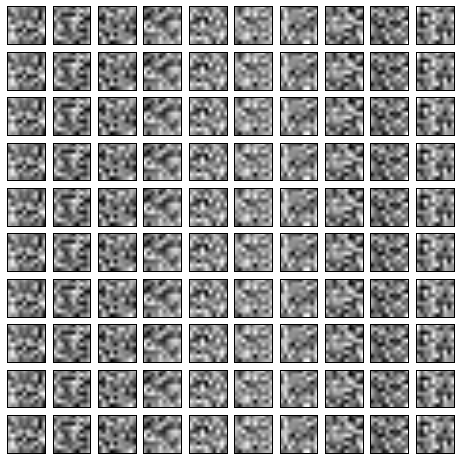

In [40]:
f, axarr = plt.subplots(10, 10, figsize = (8,8))
indices = np.linspace(0,45,10).astype(int)

i = 0
for ind in indices:
    kernel1 = kernel1s[str(ind)]
    for j in range(10):
        axarr[i, j].imshow(kernel1[:,:,0,j+10],cmap = 'gray')
        axarr[i, j].get_xaxis().set_visible(False)
        axarr[i, j].get_yaxis().set_visible(False)
    i += 1

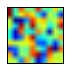

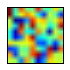

In [47]:
plt.figure(figsize=(1,1))
plt.imshow(kernel1s['0'][:,:,0,19])
plt.xticks([]), plt.yticks([]);
plt.figure(figsize=(1,1))
plt.imshow(kernel1s['45'][:,:,0,19])
plt.xticks([]), plt.yticks([]);